# Forest Classifier for PairWise Classification of Trimer Data Sets

## Required Imports

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import time
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

sns.set(style='darkgrid')

## Load the data

In [32]:
option_df = int(input('Options: \n1.Read Training Data + Test Data\n2.Read Test Data\n3.Read Test Data for Sibling Groups Only'))
if (option_df == 1):
    df_train = pd.read_csv('../03_SourceFiles/03_ProcessedFiles/trimer-pair-wise-train-df.csv',
                            engine='c',
                            index_col=0,
                            low_memory=False).sample(frac=1).reset_index(drop=True)
    df_test = pd.read_csv('../03_SourceFiles/03_ProcessedFiles/trimer-pair-wise-test-df.csv',
                            engine='c',
                            index_col=0,
                            low_memory=False).sample(frac=1).reset_index(drop=True)
    
    X_train = df_train.drop(['l_sampleName', 'r_sampleName', 'c_sampleName', 'sibling'], axis = 1).values
    y_train = df_train['sibling'].copy().values
    X_test = df_test.drop(['l_sampleName', 'r_sampleName', 'c_sampleName', 'sibling'], axis = 1).values
    y_test = df_test['sibling'].copy().values
                    
elif (option_df == 2):
    df_test = pd.read_csv('../03_SourceFiles/03_ProcessedFiles/trimer-pair-wise-test-df.csv',
                            engine='c',
                            index_col=0,
                            low_memory=False).sample(frac=1).reset_index(drop=True)

    X_test = df_test.drop(['l_sampleName', 'r_sampleName', 'c_sampleName', 'sibling'], axis = 1).values
    y_test = df_test['sibling'].copy().values

elif (option_df == 3):
    df_test = pd.read_csv('../03_SourceFiles/03_ProcessedFiles/trimer-pair-wise-test-df-proba.csv',
                            engine='c',
                            index_col=0,
                            low_memory=False).sample(frac=1).reset_index(drop=True)
    
    X_test = df_test.drop(['l_sampleName', 'r_sampleName', 'c_sampleName', 'sibling', 'siblingName'], axis = 1).values
    y_test = df_test['sibling'].copy().values

## Scale the data

In [33]:
scaler_file_name = 'StandardScalerPairWise.pkl'
if (input('Scaled the data? y/n').lower() == 'y'):
    if (input('Read scaler from memory?').lower() == 'y'):
        
        with open(scaler_file_name, 'rb') as file:
            feature_scaler = pickle.load(file)
        
        if (option_df ==1):
            X_train = feature_scaler.transform(X_train)

    else:
        feature_scaler = StandardScaler()
        X_train = feature_scaler.fit_transform(X_train)
        with open(scaler_file_name, 'wb') as file:
            pickle.dump(feature_scaler, file)

    X_test = feature_scaler.transform(X_test)

## Visualize Pre Existing Test Data

In [34]:
value_counts = df_test[(df_test['siblingName'] != '0')]['siblingName'].value_counts()

In [35]:
list(value_counts[(value_counts > 3)].index)

['20171003-22WIooPA-VT-3_RN1',
 '20150201-63OOknUD-OO-3_RN1',
 '20150819-14OObsUD-OO-3_RN1',
 '20150922-07AAcsUD-OO-3_RN1',
 '20150922-07AAcsUD-OO-3_RN3',
 '20150201-7MLdcOO-SM-3_RN3',
 '20150707-07DGplUD-OO-3_RN1',
 '20160216-13DEgaDH-OO-3_RN1',
 '20150201-7MLdcOO-SM-3_RN2',
 '20171128-71NYsaVH-VG-3_RN2',
 '20171003-09WIooPA-VT-3_RN1',
 '20160216-13DGctDH-OO-3_RN1',
 '20171003-09WIsaSP-VT-3_RN2',
 '20150201-101OOooAM-WM-3_RN1',
 '20150922-07AAbwUD-OO-3_RN3',
 '20150201-100OOooNA-WM-3_RN1',
 '20170713-37OOooOS-HD-3_RN1',
 '20170808-105OOooNA-NE-3_RN1',
 '20170808-103OOooNA-NE-3_RN1',
 '20170808-93OOooOS-HD-3_RN1',
 '20150819-07OOplUD-OO-3_RN2',
 '20170808-101OOooNA-NE-3_RN1',
 '20170713-31OOooNA-HD-3_RN1',
 '20170808-06WIsaHE-VT-3_RN1',
 '20170601-45OOooOS-HD-3_RN1',
 '20140701-07RHasUD-OO-3_RN1',
 '20170504-25OOooNA-HD-3_RN1',
 '20170228-23ARooOO-HD-3_RN1',
 '20170404-29OOooLI-HD-3_RN1',
 '20151124-07MEcaUD-OO-3_RN1',
 '20170504-25OOooLI-HD-3_RN1',
 '20170713-48OOooOS-HD-3_RN1',
 '201

In [7]:
# 117 Groups
# Avg Group Member Permutations: 25

In [36]:
## Train or Load Model:
# classifierFileName = 'PairWiseForestClassifier.pkl'
classifierFileName = 'random_forest_classifier_august10.pkl'

trainingChoice = input('Train Model or Load it? T or L').upper()

if (trainingChoice == 'T'):
    classifier = RandomForestClassifier(bootstrap=False, max_depth=50, max_features='sqrt',
                       min_samples_leaf=2, n_estimators=800)
    classifier.fit(X_train, y_train)
    with open(classifierFileName, 'wb') as file:
        pickle.dump(classifier, file)

elif (trainingChoice == 'L'):
    with open(classifierFileName, 'rb') as file:
        classifier = pickle.load(file)

In [37]:
prediction = classifier.predict(X_test)

In [38]:
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve

<Figure size 720x504 with 0 Axes>

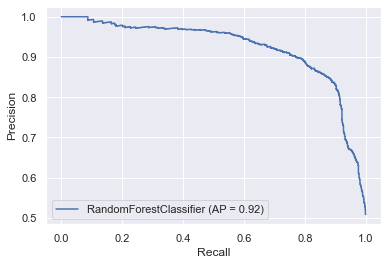

In [39]:
plt.figure(figsize=(10,7))
displ = plot_precision_recall_curve(classifier, X_test, y_test)

In [10]:
df_test_p = df_test.copy()

In [11]:
df_test_p['prediction'] = prediction

In [12]:
print(classification_report(y_test, prediction))

precision    recall  f1-score   support

           0       0.73      0.97      0.83      1500
           1       0.94      0.61      0.74      1386

    accuracy                           0.79      2886
   macro avg       0.84      0.79      0.78      2886
weighted avg       0.83      0.79      0.79      2886



In [13]:
df_test_p_sibling = df_test_p[(df_test_p['siblingName'] != '0')]

In [14]:
# This create a dataframe that only contains records for siblings/permutations that have more than 3 members in a group. This is to do the brother of brother calculation.

df_test_p_sibling_counts = df_test_p[df_test_p['siblingName'].isin(list(value_counts[(value_counts > 3)].index))]

In [15]:
df_test_p_sibling_counts

,l_sampleName,l_TYA,l_LDV,l_AWL,l_WLD,l_YAW,l_HQH,l_SGQ,l_DHQ,l_GQD,...,r_EMC,r_FCM,r_CWW,r_WWC,r_CWV,r_naiveLibrary,sibling,c_sampleName,siblingName,prediction
1,20160216-13DEgaDH-OO-3__R8F8_RN1RP2,31.0,1.0,0.0,5.0,21.0,53.0,11.0,15.0,16.0,...,0.0,0.0,0.0,0.0,0.0,0,1,20160216-13DEgaDH-OO-3__R8F8_RN1RP2_^_20160216...,20160216-13DEgaDH-OO-3_RN1,1
5,20170808-93OOooOS-HD-3__R4F11_RN1RP4,13.0,2.0,4.0,8.0,2.0,7.0,1.0,3.0,6.0,...,0.0,0.0,0.0,1.0,0.0,1,1,20170808-93OOooOS-HD-3__R4F11_RN1RP4_^_2017080...,20170808-93OOooOS-HD-3_RN1,0
6,20150819-07OOplUD-OO-3__R5F13_RN2RP1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,20150819-07OOplUD-OO-3__R5F13_RN2RP1_^_2015081...,20150819-07OOplUD-OO-3_RN2,0
7,20150819-14OObsUD-OO-3__R9F14_RN1RP6,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,20150819-14OObsUD-OO-3__R9F14_RN1RP6_^_2015081...,20150819-14OObsUD-OO-3_RN1,0
12,20150922-07AAcsUD-OO-3__R8F2_RN1RP2,689.0,741.0,699.0,695.0,676.0,220.0,163.0,156.0,129.0,...,0.0,0.0,0.0,0.0,0.0,0,1,20150922-07AAcsUD-OO-3__R8F2_RN1RP2_^_20150922...,20150922-07AAcsUD-OO-3_RN1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,20150201-7MLdcOO-SM-3__R3F8_RN3RP2,43.0,42.0,42.0,42.0,42.0,16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1,20150201-7MLdcOO-SM-3__R3F8_RN3RP2_^_20150201-...,20150201-7MLdcOO-SM-3_RN3,0
2881,20150529-07AAplUD-OO-3__R1F15_RN2RP2,0.0,1.0,0.0,73.0,0.0,1.0,4.0,0.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0,1,20150529-07AAplUD-OO-3__R1F15_RN2RP2_^_2015052...,20150529-07AAplUD-OO-3_RN2,1
2882,20170202-13OOooOO-YC-3__R7F9_RN1RP3,70.0,11.0,0.0,5.0,3.0,23.0,22.0,34.0,46.0,...,0.0,0.0,0.0,0.0,0.0,1,1,20170202-13OOooOO-YC-3__R7F9_RN1RP3_^_20170202...,20170202-13OOooOO-YC-3_RN1,0
2883,20160216-13DEgaDH-OO-3__R8F20_RN1RP2,39.0,2.0,13.0,0.0,3.0,86.0,41.0,3.0,79.0,...,0.0,0.0,0.0,0.0,0.0,0,1,20160216-13DEgaDH-OO-3__R8F20_RN1RP2_^_2016021...,20160216-13DEgaDH-OO-3_RN1,1


In [16]:
df_preds = df_test_p_sibling_counts[['l_sampleName', 'r_sampleName', 'c_sampleName', 'sibling', 'siblingName', 'prediction']].copy()

,l_sampleName,r_sampleName,c_sampleName,sibling,siblingName,prediction
1,20160216-13DEgaDH-OO-3__R8F8_RN1RP2,20160216-13DEgaDH-OO-3__R8F9_RN1RP3,20160216-13DEgaDH-OO-3__R8F8_RN1RP2_^_20160216...,1,20160216-13DEgaDH-OO-3_RN1,1
5,20170808-93OOooOS-HD-3__R4F11_RN1RP4,20170808-93OOooOS-HD-3__R4F10_RN1RP3,20170808-93OOooOS-HD-3__R4F11_RN1RP4_^_2017080...,1,20170808-93OOooOS-HD-3_RN1,0
6,20150819-07OOplUD-OO-3__R5F13_RN2RP1,20150819-07OOplUD-OO-3__R5F14_RN2RP2,20150819-07OOplUD-OO-3__R5F13_RN2RP1_^_2015081...,1,20150819-07OOplUD-OO-3_RN2,0
7,20150819-14OObsUD-OO-3__R9F14_RN1RP6,20150819-14OObsUD-OO-3__R9F12_RN1RP6,20150819-14OObsUD-OO-3__R9F14_RN1RP6_^_2015081...,1,20150819-14OObsUD-OO-3_RN1,0
12,20150922-07AAcsUD-OO-3__R8F2_RN1RP2,20150922-07AAcsUD-OO-3__R8F15_RN1RP3,20150922-07AAcsUD-OO-3__R8F2_RN1RP2_^_20150922...,1,20150922-07AAcsUD-OO-3_RN1,1
...,...,...,...,...,...,...
2880,20150201-7MLdcOO-SM-3__R3F8_RN3RP2,20150201-7MLdcOO-SM-3__R3F4_RN3RP1,20150201-7MLdcOO-SM-3__R3F8_RN3RP2_^_20150201-...,1,20150201-7MLdcOO-SM-3_RN3,0
2881,20150529-07AAplUD-OO-3__R1F15_RN2RP2,20150529-07AAplUD-OO-3__R1F14_RN2RP1,20150529-07AAplUD-OO-3__R1F15_RN2RP2_^_2015052...,1,20150529-07AAplUD-OO-3_RN2,1
2882,20170202-13OOooOO-YC-3__R7F9_RN1RP3,20170202-13OOooOO-YC-3__R7F10_RN1RP4,20170202-13OOooOO-YC-3__R7F9_RN1RP3_^_20170202...,1,20170202-13OOooOO-YC-3_RN1,0
2883,20160216-13DEgaDH-OO-3__R8F20_RN1RP2,20160216-13DEgaDH-OO-3__R8F19_RN1RP1,20160216-13DEgaDH-OO-3__R8F20_RN1RP2_^_2016021...,1,20160216-13DEgaDH-OO-3_RN1,1


In [54]:
series_prediction_count = df_preds[(df_preds['prediction'] == 1)].groupby('siblingName')['prediction'].value_counts()
series_sibling_count = df_test['siblingName'].value_counts()

df_prediction_count = series_prediction_count.unstack()
# df_pred_diff = pd.merge(left = series_sibling_count, right = series_prediction_count, how='outer', indicator=True)

AttributeError: 'Index' object has no attribute 'remove_unused_levels'

In [52]:
df_prediction_count.rename(columns={1: 'predictCorrectCount'}, inplace=True)

In [57]:
df_prediction_count.merge(right=series_sibling_count, how='outer', right_index=True, left_index=True, indicator=True).to_csv('prediction_count_use.csv')

In [2]:
df_prediction_count

NameError: name 'df_prediction_count' is not defined

In [31]:
series_prediction_count

siblingName                 prediction
20140701-07MLdcMM-OO-3_RN1  1              6
20140701-07MLdcUD-OO-3_RN1  1              6
20140701-07MSdcDA-OO-3_RN1  1              6
20140701-07MSdcMM-OO-3_RN1  1              6
20140701-07RHasUD-OO-3_RN1  1             12
                                          ..
20180222-24WIooVH-VG-3_RN1  1              1
20180222-57NYooVH-VT-3_RN1  1              6
20180222-57WIsaVL-VT-3_RN1  1              6
20180522-06WIsaVL-VT-3_RN1  1              1
20180809-71MLbgBU-DV-3_RN1  1              1
Name: prediction, Length: 79, dtype: int64

In [41]:
df_preds.to_csv('sibling-counts-predictions.csv')

In [24]:
series_prediction_count.to_csv('test2.csv')

In [26]:
series_sibling_count

0                             1500
20171003-22WIooPA-VT-3_RN1     156
20150201-63OOknUD-OO-3_RN1     110
20150922-07AAcsUD-OO-3_RN1      42
20150819-14OObsUD-OO-3_RN1      42
                              ... 
20160816-07GAbgUD-CL-3_RN0       2
20180809-71MLbcBU-DF-3_RN1       2
20160602-13OOicPA-JW-3_RN2       2
20171106-71ZJgoHE-DF-3_RN1       2
20160816-07GUooOO-BT-3_RN0       2
Name: siblingName, Length: 117, dtype: int64